In [1]:

import numpy as np 
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"/openmd")

from SimulatorLJ import SimulatorLJ as Simulator

def initialize(num_part, sigma, length):
    """
    :param num_part:
    :type num_part:
    :return:
    :rtype:
    """
    coordinates = np.zeros((num_part, 3))
    pos_x = (0, length, 2**(1/6)*sigma)
    i = 0
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                coordinates[i, :] = np.array([x , y ,z])
                i += 1
                if i == num_part-1:
                    break
            if i == num_part - 1:
                break
        if i == num_part - 1:
            break
    return coordinates

coordinates = initialize(64, 1, 6)
velocities = np.zeros((64,3))
sim = Simulator(
    mass = 1,
    sim_time= 100,
    time_step = 1,
    initial_values = [coordinates,velocities],
    box_length = 6 ,
    force=None,
    force_constants=[1, 1],
    integrator=None,
    periodic=True,
)
positions, velocities = sim.simulate()

/home/julian/Documents/openmd/openmd


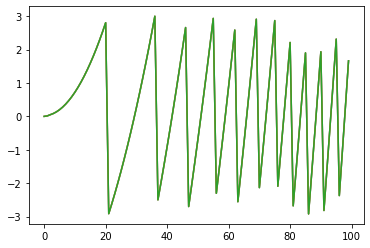

In [2]:
import matplotlib.pyplot as plt 
plt.plot(positions[0,:,:].T)

In [4]:
from numba import njit
@njit()
def force_lj_fast(self, positions, constants, box_length):
    """
    :param positions:
    :type positions:
    :param constants:
    :type constants:
    :param box_length:
    :type box_length:
    :return:
    :rtype:
    """
    epsilon, sigma = constants
    num = positions.shape[0]
    force = np.zeros((num, num, 3))
    for i in range(0, num - 1):
        for j in range(i + 1, num):
            difference = positions[j, :] - positions[i, :]
            distance = np.linalg.norm(difference)
            if distance > box_length / 2:
                distance -= box_length / 2
            elif distance <= -box_length / 2:
                distance += box_length / 2
            lj_part = (sigma / distance) ** 6
            lj_part_two = lj_part ** 2
            factor = 24 * epsilon
            factor_two = 2 * factor
            force[i, j, :] = (factor_two * lj_part_two - factor * lj_part) / distance
            force[j, i, :] -= force[i, j, :]

    return np.sum(force, axis=1)

ImportError: Numba needs NumPy 1.21 or less

In [4]:
sim.force = force_lj_fast

NameError: name 'force_lj_fast' is not defined